# Customer Segmentation Project

## Objective
Segment customers based on their purchasing behavior to help a retail company understand different customer groups and tailor marketing strategies.


In [1]:
# Importing necessary libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.decomposition import PCA
    from mpl_toolkits.mplot3d import Axes3D
    import openpyxl

    print("Libraries imported successfully!")
except ImportError as e:
    print(f"Error importing libraries: {e}")


Libraries imported successfully!


## Data Collection
Load the dataset from the UCI Machine Learning Repository.

In [2]:
# Load the dataset with error handling
try:
    print("Attempting to load dataset...")
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
    data = pd.read_excel(url, engine='openpyxl')
    print("Dataset loaded successfully!")
    display(data.head())
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")


Attempting to load dataset...
Dataset loaded successfully!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleaning
Remove missing values, handle outliers, and create a TotalPrice column.


In [3]:
# Remove missing values
data = data.dropna()

# Remove rows with negative or zero quantity and unit price
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create a TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Verify the column is created correctly
print(data.columns)
data.head()


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Exploratory Data Analysis (EDA)
Analyze total sales and number of orders by country.


In [4]:
# Descriptive statistics
data.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


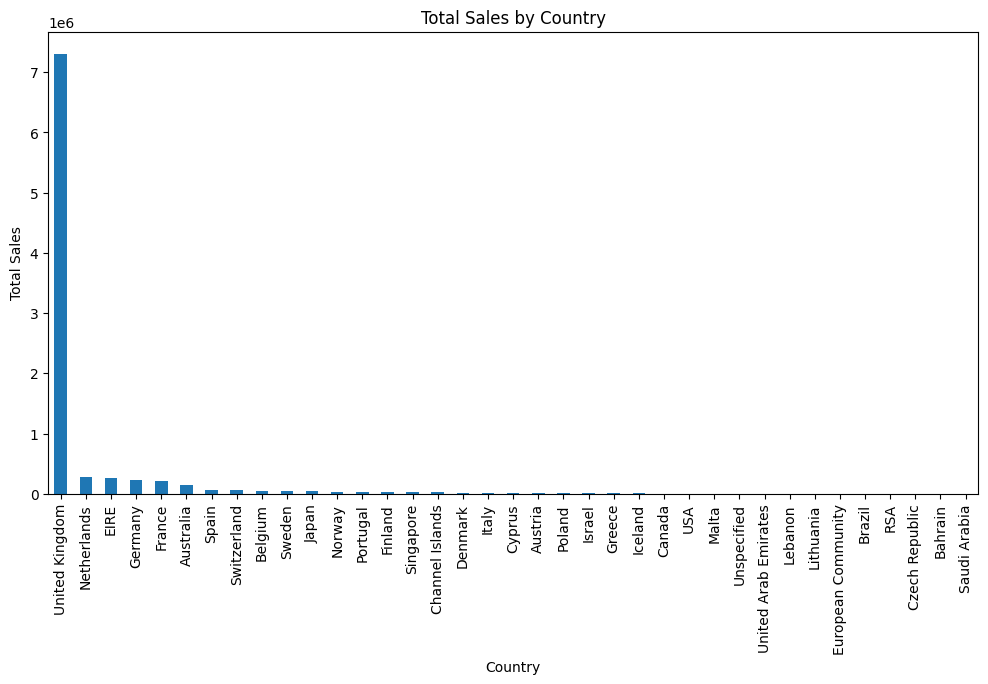

In [5]:
# Total sales by country
country_sales = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
country_sales.plot(kind='bar')
plt.title('Total Sales by Country')
plt.ylabel('Total Sales')
plt.show()


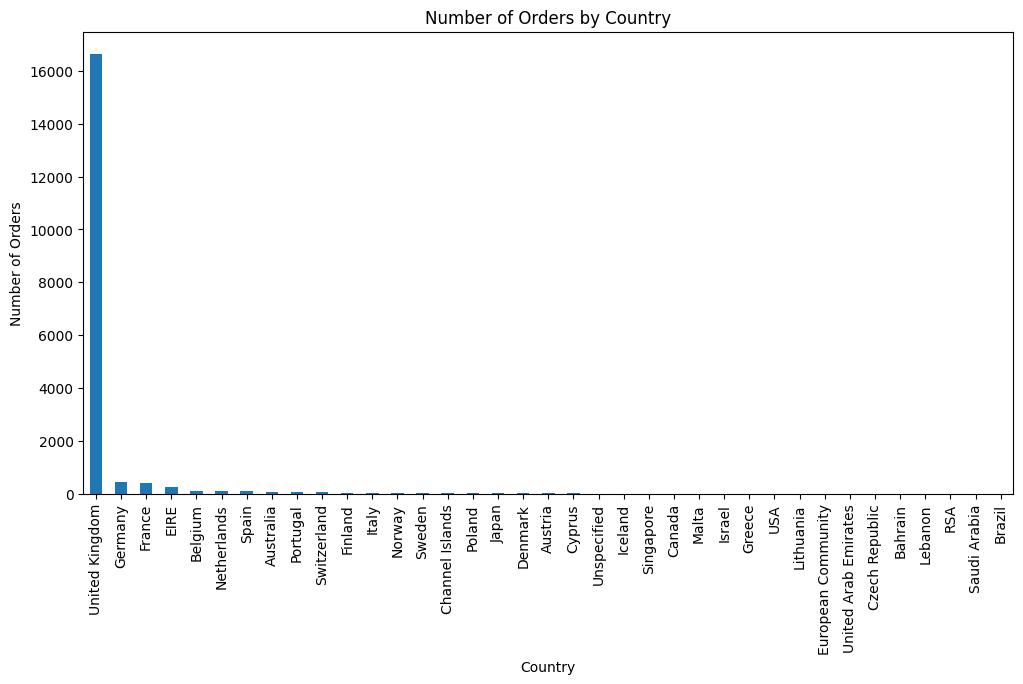

In [44]:

# Number of orders by country
country_orders = data.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
country_orders.plot(kind='bar')
plt.title('Number of Orders by Country')
plt.ylabel('Number of Orders')
plt.show()


## Feature Engineering
Calculate Recency, Frequency, and Monetary value for each customer.


In [6]:
# Calculate Recency, Frequency, and Monetary value for each customer
import datetime as dt

# Set reference date
now = dt.datetime(2011, 12, 10)

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

# Rename columns
customer_data.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
customer_data.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


## Model Selection
Determine the optimal number of clusters using the elbow method and perform clustering.


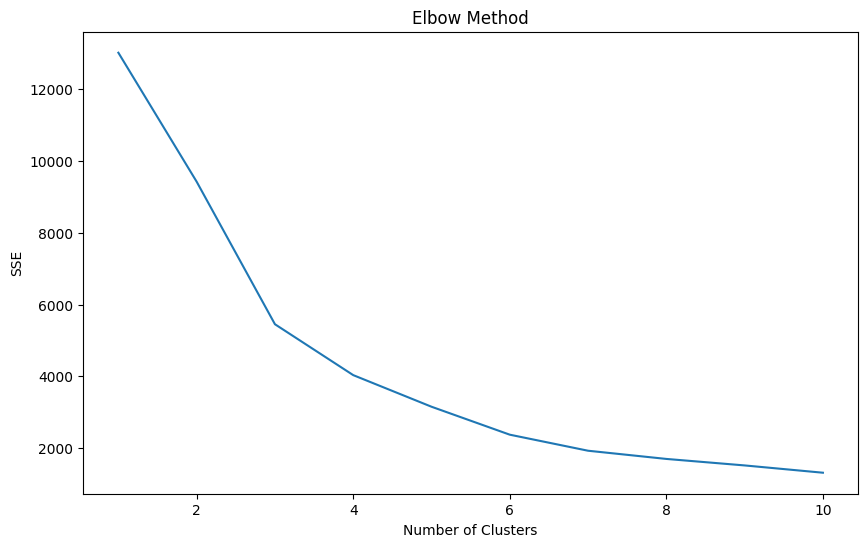

In [7]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plot SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

# Choose the optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to customer data
customer_data['Cluster'] = kmeans.labels_


## Model Training and Evaluation
Evaluate the clustering using silhouette score and visualize the clusters.


In [8]:
# Evaluate the clustering using silhouette score
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.6027560496029598


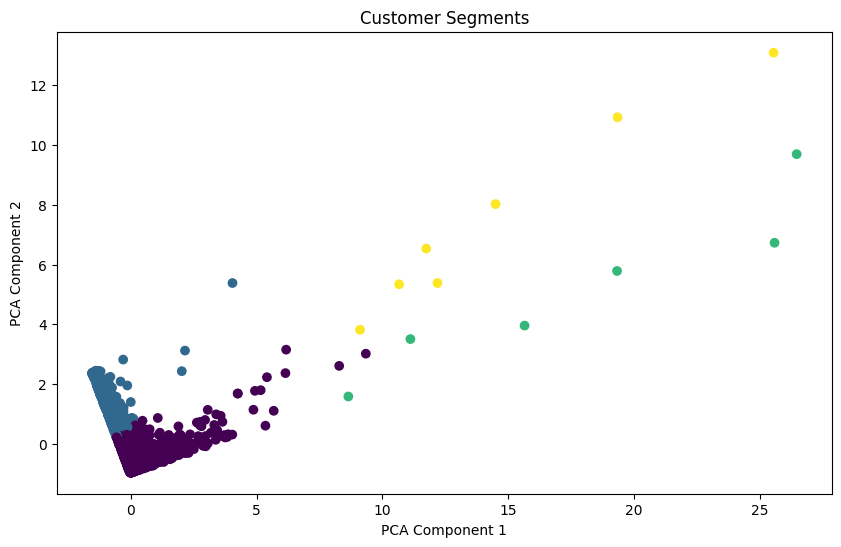

In [9]:

# Visualize clusters in a 2D plot (using PCA for dimensionality reduction)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=customer_data['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Visualization
Visualize the clusters in 3D and analyze cluster characteristics.


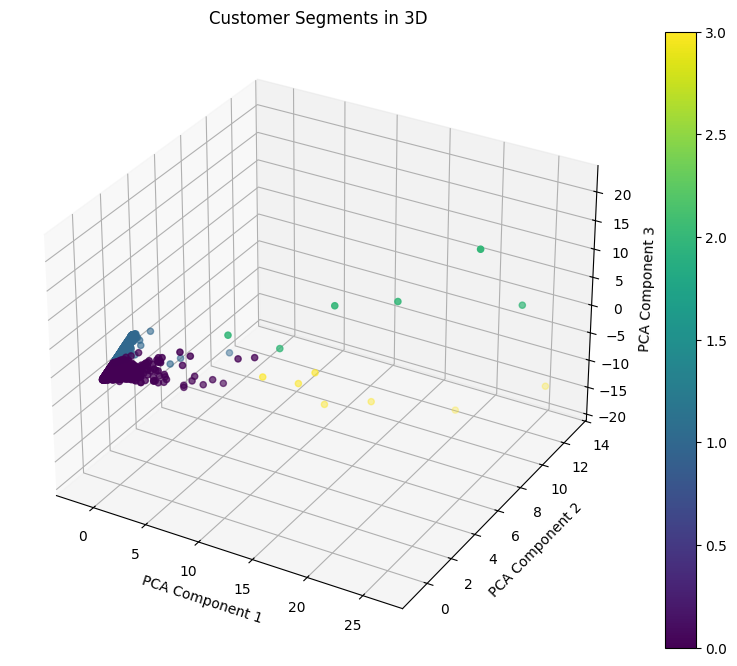

Cluster 0:
           Recency    Frequency      Monetary  Cluster
count  3245.000000  3245.000000   3245.000000   3245.0
mean     40.907242   102.830200   2043.487782      0.0
std      35.575605   141.877788   4423.090083      0.0
min       0.000000     1.000000      6.200000      0.0
25%      11.000000    25.000000    411.410000      0.0
50%      30.000000    57.000000    922.390000      0.0
75%      63.000000   123.000000   2092.320000      0.0
max     156.000000  1818.000000  81024.840000      0.0
Cluster 1:
           Recency    Frequency      Monetary  Cluster
count  1080.000000  1080.000000   1080.000000   1080.0
mean    246.813889    27.749074    636.501112      1.0
std      66.821630    31.738695   3025.386931      0.0
min     140.000000     1.000000      3.750000      1.0
25%     189.000000     9.000000    169.897500      1.0
50%     242.000000    18.000000    310.155000      1.0
75%     298.250000    33.000000    539.220000      1.0
max     373.000000   297.000000  77183.6000

In [33]:
# Visualize clusters in 3D
pca = PCA(n_components=3)
pca_data_3d = pca.fit_transform(scaled_data)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_data_3d[:, 0], pca_data_3d[:, 1], pca_data_3d[:, 2], c=customer_data['Cluster'], cmap='viridis')
plt.colorbar(sc)
plt.title('Customer Segments in 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

# Characteristics of each cluster
for cluster in range(4):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data.describe())
